# Expe 1, noise tagging condition, individual analysis of participant A2

In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A2/converted/trialinfo_matrix_A2_cleanedtrials.mat'
data_file = '/data/A2/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_2.fif'

# Posterior electrodes
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz'] 
# Best electrodes in frequency tagging condition
freqtag_electrodes = ['Iz', 'PO3', 'POz', 'P3', 'P7', 'P5']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from noise_tagging_funs import normalize_per_trial, generate_noise_periods, cross_cor_nois, bin_to_dataframe

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']

# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif ...


/tmp/ipykernel_29391/448556551.py:22: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
467 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,467
Events,1: 467
Time range,-1.000 – 2.299 s
Baseline,off


In [5]:
epochs_noistag = epochs['tagging_type==1'].copy()
# bandpass (60-80Hz) EEG data 
epochs_noistag.filter(l_freq=60, h_freq = 80, verbose=True)
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 451 samples (0.220 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s


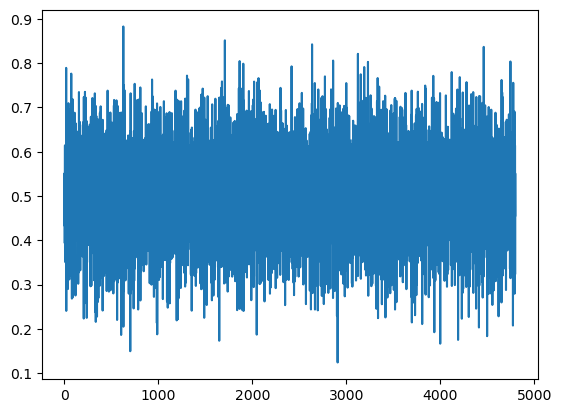

In [6]:
# First noise tag at block 15 trial 32
plt.plot((noise_stims[14,31,0,:].T+noise_stims[14,31,1,:].T)/2)
# NB : tag 1 was always displayed on the left and tag 2 on the right

In [7]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

In [8]:
noise_stims_tr.shape

(480, 2, 4800)

In [10]:
epochs_noistag.resample(480)

Number of events,233
Events,1: 233
Time range,-1.000 – 2.298 s
Baseline,off


In [20]:
sfreq = epochs_noistag.info['sfreq']
eeg_arr = epochs_noistag.get_data(copy=True)
#(make time the first dimension)
eeg_arr = np.transpose(eeg_arr, axes=(2,0,1))
n_samples, n_trials, n_channels = eeg_arr.shape
cued_noise = np.zeros((n_trials, n_samples))
i = 0
for index, row in epochs_noistag.metadata.iterrows():
    cued_noise[i] = np.where(row.cued_side == 0, noise_stims_tr[int(row.trial_number),0],noise_stims_tr[int(row.trial_number),1])[:n_samples]
    i += 1
# Prepare model data (make time the first dimension)
cued_noise = cued_noise.T[:,:,np.newaxis]

split 1 / 5
Fitting 233 epochs, 1 channels


  0%|          | Sample : 0/466 [00:00<?,       ?it/s]

split 2 / 5
Fitting 233 epochs, 1 channels


  0%|          | Sample : 0/466 [00:00<?,       ?it/s]

split 3 / 5
Fitting 233 epochs, 1 channels


  0%|          | Sample : 0/466 [00:00<?,       ?it/s]

split 4 / 5
Fitting 233 epochs, 1 channels


  0%|          | Sample : 0/466 [00:00<?,       ?it/s]

split 5 / 5
Fitting 233 epochs, 1 channels


  0%|          | Sample : 0/466 [00:00<?,       ?it/s]

[Text(0.5, 1.0, 'Mean prediction score'),
 Text(0.5, 0, 'Channel'),
 Text(0, 0.5, 'Score ($r$)')]

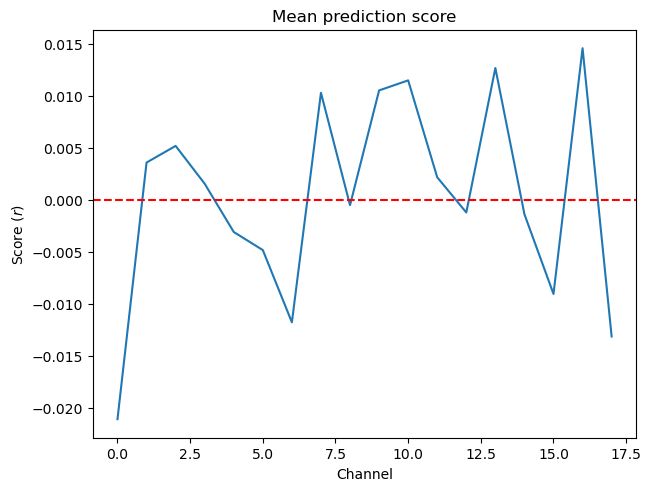

In [26]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from mne.decoding import ReceptiveField

tmin, tmax = 0, 0.4
# Initialize the model
rf = ReceptiveField(
    tmin, tmax, sfreq, estimator=1.0, scoring="corrcoef"
)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 5
cv = KFold(n_splits)


# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays-1))
scores = np.zeros((n_splits, n_channels))
for ii, (train, test) in enumerate(cv.split(cued_noise)):
    print(f"split {ii + 1} / {n_splits}")
    rf.fit(cued_noise[train], eeg_arr[train])
    scores[ii] = rf.score(cued_noise[test], eeg_arr[test])
    # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 feature
    coefs[ii] = rf.coef_[:, 0, :]
times = rf.delays_ / float(rf.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_scores = scores.mean(axis=0)

# Plot mean prediction scores across all channels
fig, ax = plt.subplots(layout="constrained")
ix_chs = np.arange(n_channels)
ax.plot(ix_chs, mean_scores)
ax.axhline(0, ls="--", color="r")
ax.set(title="Mean prediction score", xlabel="Channel", ylabel="Score ($r$)")


[Text(0.5, 1.0, 'Topomap of model coefficients\nfor delay 0.39')]

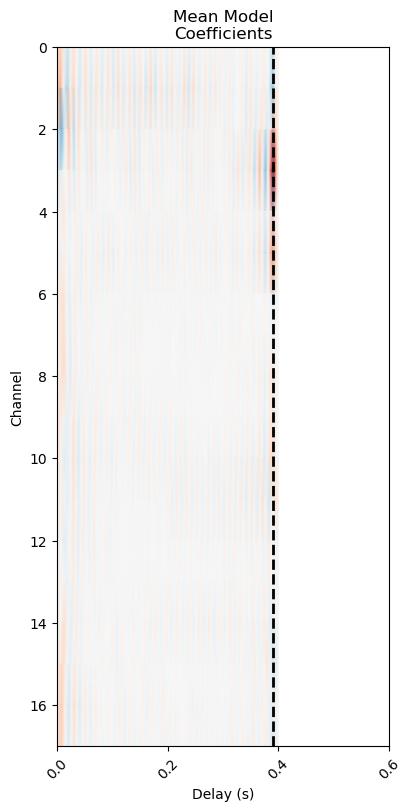

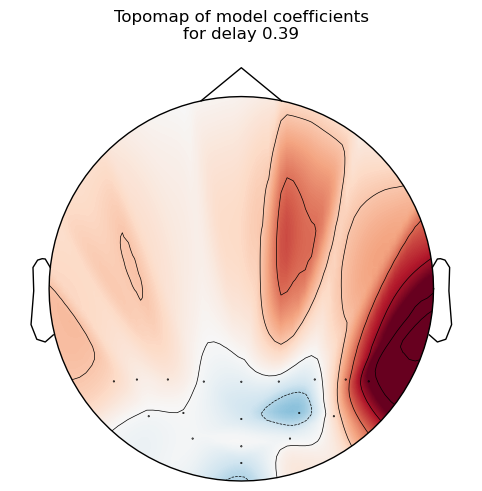

In [27]:
# Print mean coefficients across all time delays / channels (see Fig 1)
time_plot = 0.39  # For highlighting a specific time.
fig, ax = plt.subplots(figsize=(4, 8), layout="constrained")
max_coef = mean_coefs.max()
ax.pcolormesh(
    times,
    ix_chs,
    mean_coefs,
    cmap="RdBu_r",
    vmin=-max_coef,
    vmax=max_coef,
    shading="gouraud",
)
ax.axvline(time_plot, ls="--", color="k", lw=2)
ax.set(
    xlabel="Delay (s)",
    ylabel="Channel",
    title="Mean Model\nCoefficients",
    xlim=times[[0, -1]],
    ylim=[len(ix_chs) - 1, 0],
    xticks=np.arange(tmin, tmax + 0.2, 0.2),
)
plt.setp(ax.get_xticklabels(), rotation=45)

# Make a topographic map of coefficients for a given delay (see Fig 2C)
ix_plot = np.argmin(np.abs(time_plot - times))
fig, ax = plt.subplots(layout="constrained")
mne.viz.plot_topomap(
    mean_coefs[:, ix_plot], pos=epochs_noistag.info, axes=ax, show=False, vlim=(-max_coef, max_coef)
)
ax.set(title="Topomap of model coefficients\nfor delay %s" % time_plot)

In [23]:
sr = ReceptiveField(
    tmin,
    tmax,
    sfreq,
    feature_names=epochs_noistag.ch_names,
    estimator=1e4,
    scoring="corrcoef",
    patterns=True,
)
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 2

n_splits = 3
cv = KFold(n_splits)

# Iterate through splits, fit the model, and predict/test on held-out data
coefs = np.zeros((n_splits, n_channels, n_delays-1))
patterns = coefs.copy()
scores = np.zeros((n_splits,))
for ii, (train, test) in enumerate(cv.split(cued_noise)):
    print(f"split {ii + 1} / {n_splits}")
    sr.fit(eeg_arr[train], cued_noise[train])
    scores[ii] = sr.score(eeg_arr[test], cued_noise[test])[0]
    # coef_ is shape (n_outputs, n_features, n_delays). We have 128 features
    coefs[ii] = sr.coef_[0, :, :]
    patterns[ii] = sr.patterns_[0, :, :]
times = sr.delays_ / float(sr.sfreq)

# Average scores and coefficients across CV splits
mean_coefs = coefs.mean(axis=0)
mean_patterns = patterns.mean(axis=0)
mean_scores = scores.mean(axis=0)
max_coef = np.abs(mean_coefs).max()
max_patterns = np.abs(mean_patterns).max()

split 1 / 3
Fitting 233 epochs, 18 channels


  0%|          | Sample : 0/44037 [00:00<?,       ?it/s]

split 2 / 3
Fitting 233 epochs, 18 channels


  0%|          | Sample : 0/44037 [00:00<?,       ?it/s]

split 3 / 3
Fitting 233 epochs, 18 channels


  0%|          | Sample : 0/44037 [00:00<?,       ?it/s]

(0.0, 1.0)

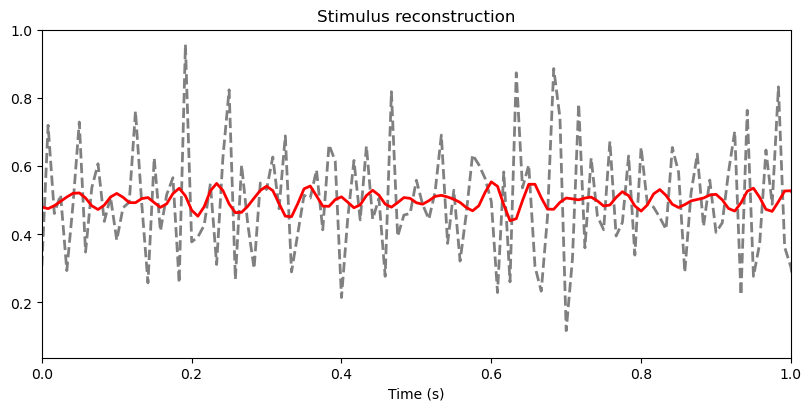

In [24]:
y_pred = sr.predict(eeg_arr[test])
time = np.linspace(0, 2.0, 5 * int(sfreq))
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
ax.plot(
    time[::10], cued_noise[test][sr.valid_samples_, 0,0][: int(5 * sfreq)], color="grey", lw=2, ls="--"
)

ax.plot(time[::10], y_pred[sr.valid_samples_, 0, 0][: int(5 * sfreq)], color="r", lw=2)
# ax.legend([lns[0], ln1[0]], ["Envelope", "Reconstruction"], frameon=False)
ax.set(title="Stimulus reconstruction")
ax.set_xlabel("Time (s)")
ax.set_xlim(0,1)